# aws-smsl-predict-airquality-via-weather
A Jupyter Notebook that connects to Amazon Sustainability Data Initiative (ASDI) datasets from NOAA and OpenAQ to build a Machine Learning (ML) model to predict air quality via weather.

## PROBLEM: 1 out of 8 deaths in the world is due to poor air quality (source: OpenAQ.org)
This notebook explores correlations between weather and air quality since we know factors like temperatures, wind speeds, etc, affect certain air quality parameters. Predicting air quality based on weather can get into highly sophisticated ML techniques, but this demo shows how merging NOAA GSOD weather data with OpenAQ air quality data to build an ML model using AutoGluon (AutoML from AWS) can result in prediction accuracy of ~75-85% using Binary Classification models for the Los Angeles, CA, and Las Vegas, NV areas for a target parameter of 2.5 micron Particulate Matter (PM2.5).

## INSTRUCTIONS
- Configure your environment using the environment.yml file or by running the *pip install* commands below.
- Review the predefined parameter options (Cell #3) and select which to use (Cell #4). You can also edit these and/or use your own.
- Step through and run the various cells in the notebook to access ASDI datasets, prep data, merge data, and build+visualize your model.

In [1]:
# Set up your environment according to the environment.yml file or run the following...
# %pip install boto3
# %pip install pandas
# %pip install numpy
# %pip install requests
# %pip install ipywidgets
# %pip install scikit-learn
# %pip install autogluon

In [2]:
# Some import statements and global vars to make things more dynamic...
import os
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import requests
import json

from botocore import UNSIGNED
from botocore.config import Config
from io import StringIO
from types import SimpleNamespace

In [3]:
# Declaration of global vars used through and also location + AQ options...
useLocalDataFilesIfTheyExist = True    # True => Prevents re-fetching of data, if it's already been accessed and prepared
targetLabelName  = 'isUnhealthy'       # Makes for easy + consistent reference to our target label
eval_metric      = 'accuracy'          # Binary Classification evaluation metric to best fit
time_limit_secs  = None                # Autogluon time_limit in seconds, eg: 60*5 = 300 => 5mins; None => Use Default
fitIgnoreColumns = ['DATE','NAME','day','unit','average','parameter']  # Not relevant as features for training/fit

# NOAA Station IDs: 72287493134=Downtown Los Angeles (USC), California, USA; 72484653123=Las Vegas-Paradise, NV, USA; etc
# SEARCH NOAA Station IDs: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# OpenAQ Location IDs: 7936="Los Angeles - N. Main"; 1948="Compton"; 8730="Pasadena"; 344="Las Vegas-Paradise"; etc
# SEARCH OpenAQ Locations: https://api.openaq.org/docs#/v2/locations_get_v2_locations_get
locationsData = {
    "key_columns" : ["DATE","NAME","DEWP","WDSP","MAX","MIN","PRCP"],
    "los_angeles" : { "name": "los-angeles", "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "72287493134", "openAqLocIDs": ["7936","1948"] },
    "bakersfield" : { "name": "bakersfield", "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "72384023155", "openAqLocIDs": ["788","6885"] },
    "fresno"      : { "name": "fresno",      "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "72389093193", "openAqLocIDs": ["790","895"] },
    "fairbanks"   : { "name": "fairbanks",   "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "70261026411", "openAqLocIDs": ["1880"] },
    "phoenix"     : { "name": "phoenix",     "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "72278023183", "openAqLocIDs": ["514","526","2225"] },
    "las_vegas"   : { "name": "las-vegas",   "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "72484653123", "openAqLocIDs": ["344","1013"] },
    "lahore_pk"   : { "name": "lahore-pk",   "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "41640099999", "openAqLocIDs": ["8664"] },
    # "hotan_cn"    : { "name": "hotan-cn",    "yearStart": 2016, "yearEnd": 2022, "noaaStationID": "51828099999", "openAqLocIDs": ["10091","10304","7699","7688"] },
}
locations = json.loads(json.dumps(locationsData), object_hook=lambda d: SimpleNamespace(**d))

# Define aqParams with added thresholds; based on OpenAQ API call where isCore=true (https://api.openaq.org/v2/parameters)
# Thresholds from EPA.gov using strictest values or values most relevant to a given day's exposure (https://www.epa.gov/criteria-air-pollutants/naaqs-table)
# Confirm and adjust params or thresholds as needed for your purposes...
aqParamsData = {
    "key_columns" : ["day","parameter","unit","average"],
    "pm10"   : { "id": 1, "name": "pm10", "unit": "µg/m³", "unhealthyThreshold": 150.0, "desc": "Particulate Matter < 10 micrometers" },
    "pm25"   : { "id": 2, "name": "pm25", "unit": "µg/m³", "unhealthyThreshold":  12.0, "desc": "Particulate Matter < 2.5 micrometers" },
    "no2"    : { "id": 7, "name": "no2",  "unit": "ppm",   "unhealthyThreshold": 100.0, "desc": "Nitrogen Dioxide" },
    "co"     : { "id": 8, "name": "co",   "unit": "ppm",   "unhealthyThreshold":   9.0, "desc": "Carbon Monoxide" },
    "so2"    : { "id": 9, "name": "so2",  "unit": "ppm",   "unhealthyThreshold":  75.0, "desc": "Sulfur Dioxide" },
    "o3"     : { "id":10, "name": "o3",   "unit": "ppm",   "unhealthyThreshold": 0.070, "desc": "Ozone" },
}
aqParams  = json.loads(json.dumps(aqParamsData), object_hook=lambda d: SimpleNamespace(**d))
print("Variables and options data is defined.")

Variables and options data is defined.


In [4]:
##### CHOOSE YOUR OWN ADVENTURE HERE... ####
# Assign what you want to use in this Notebook...
locations.active = locations.fresno
aqParams.target = aqParams.pm25                     # NOTE: nearly all testing was done using pm25.
print("Input Location: " + locations.active.name)
print("Target AQ Param: " + aqParams.target.name)

Input Location: fresno
Target AQ Param: pm25


In [5]:
# ASDI Dataset Name: NOAA GSOD
# ASDI Dataset URL : https://registry.opendata.aws/noaa-gsod/
# NOAA GSOD README : https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt
# NOAA GSOD Station Search: https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day
# NOAA GSOD data in S3 is organized by year and Station ID values, so this is straight-forward
# Example S3 path format => s3://noaa-gsod-pds/{yyyy}/{stationid}.csv
# Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
noaagsod_df = pd.DataFrame()
localDataNOAA = f'dataNOAA_{locations.active.name}_{locations.active.yearStart}-{locations.active.yearEnd}.csv'

if useLocalDataFilesIfTheyExist == True and os.path.exists(localDataNOAA):
    # Use local data file already accessed + prepared...
    print('Loading NOAA GSOD data from local file: ', localDataNOAA)
    noaagsod_df = pd.read_csv(localDataNOAA)
else:
    # Access + prepare data and save to a local data file...
    print('Accessing and preparing data from ASDI-hosted NOAA GSOD dataset (Amazon S3)...')
    noaagsod_bucket = 'noaa-gsod-pds'
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

    for year in range(locations.active.yearStart, locations.active.yearEnd + 1):
        key = f'{year}/{locations.active.noaaStationID}.csv'                                         # Compute the key to get
        csv_obj = s3.get_object(Bucket=noaagsod_bucket, Key=key)                                     # Get the S3 object
        csv_string = csv_obj['Body'].read().decode('utf-8')                                          # Read object contents to a string
        noaagsod_df = pd.concat([noaagsod_df, pd.read_csv(StringIO(csv_string))], ignore_index=True) # Use the string to build the DataFrame

    # Trim down to the desired key columns...
    noaagsod_df = noaagsod_df[locations.key_columns]

    # Perform some Feature Engineering to append potentially useful columns to our dataset...
    # It may be true that Day of Week affects air quality (ie: higher weekday commuting/industrial pollutants; not very correlated after all)
    # It may be true that Month of Year affects air quality (ie: seasonal considerations; tends to have correlation for certain areas)
    noaagsod_df['DAYOFWEEK'] = pd.to_datetime(noaagsod_df['DATE']).dt.dayofweek + 1
    noaagsod_df['MONTH'] = pd.to_datetime(noaagsod_df['DATE']).dt.month

    # Concat/JOIN the new DAYOFWEEK column to our NOAA GSOD DataFrame AND save as CSV...
    noaagsod_df.to_csv(localDataNOAA, index=False)

# Output noaagsod_df properties...
print('noaagsod_df.shape =', noaagsod_df.shape)
display(noaagsod_df)

Loading NOAA GSOD data from local file:  dataNOAA_fresno_2016-2022.csv
noaagsod_df.shape = (2349, 9)


,DATE,NAME,DEWP,WDSP,MAX,MIN,PRCP,DAYOFWEEK,MONTH
0,2016-01-01,"FRESNO YOSEMITE INTERNATIONAL, CA US",32.4,1.4,53.1,28.9,0.00,5,1
1,2016-01-02,"FRESNO YOSEMITE INTERNATIONAL, CA US",34.9,1.6,54.0,28.9,0.00,6,1
2,2016-01-03,"FRESNO YOSEMITE INTERNATIONAL, CA US",37.3,1.5,60.1,39.9,0.00,7,1
3,2016-01-04,"FRESNO YOSEMITE INTERNATIONAL, CA US",38.4,2.1,60.1,39.0,0.00,1,1
4,2016-01-05,"FRESNO YOSEMITE INTERNATIONAL, CA US",44.4,6.4,55.4,46.9,0.05,2,1
...,...,...,...,...,...,...,...,...,...
2344,2022-06-02,"FRESNO YOSEMITE INTERNATIONAL, CA US",40.9,6.5,95.0,61.0,0.00,4,6
2345,2022-06-03,"FRESNO YOSEMITE INTERNATIONAL, CA US",45.8,10.3,93.9,64.0,0.00,5,6
2346,2022-06-04,"FRESNO YOSEMITE INTERNATIONAL, CA US",51.4,9.8,91.9,63.0,0.00,6,6
2347,2022-06-05,"FRESNO YOSEMITE INTERNATIONAL, CA US",46.2,8.5,88.0,63.0,0.00,7,6


In [6]:
# ASDI Dataset Name: OpenAQ
# ASDI Dataset URL : https://registry.opendata.aws/openaq/
# OpenAQ API Docs  : https://docs.openaq.org/#/v2/
# OpenAQ S3 data is only organized by date folders, so each folder is large and contains all stations.
# Because of this, it's better to query ASDI OpenAQ data using the CloudFront-hosted API.
# Note that some days may not have values and will get filteredout via an INNER JOIN later.
# Let's start with a new DataFrame and load it from a local CSV or the NOAA data source...
aq_df = pd.DataFrame()
localDataOpenAQ = f'dataOpenAQ_{locations.active.name}_{locations.active.yearStart}-{locations.active.yearEnd}_{aqParams.target.name}.csv'
print(f'Target AQ Param: {aqParams.target.desc} (Name: {aqParams.target.name}, Unit: {aqParams.target.unit}, Unhealthy Threshold > {aqParams.target.unhealthyThreshold})')

if useLocalDataFilesIfTheyExist == True and os.path.exists(localDataOpenAQ):
    # Use local data file already accessed + prepared...
    print('Loading OpenAQ data from local file: ', localDataOpenAQ)
    aq_df = pd.read_csv(localDataOpenAQ)
else:
    # Access + prepare data and save to a local data file... (NOTE: calling OpenAQ API one year at a time to avoid timeouts)
    print('Accessing and preparing data from ASDI-hosted OpenAQ dataset (HTTPS API)...')
    aq_reqUrl = "https://u50g7n0cbj.execute-api.us-east-1.amazonaws.com/v2/averages"  # OpenAQ ASDI API Endpoint URL for averages (ie: daily averages)
    for year in range(locations.active.yearStart, locations.active.yearEnd + 1):
        aq_reqParams = {
            'date_from': f'{year}-01-01',
            'date_to': f'{year}-12-31',
            'parameter': [aqParams.target.id],
            'limit': 366,
            'page': 1,
            'offset': 0,
            'sort': 'asc',
            'spatial': 'location',
            'temporal': 'day',
            'location': locations.active.openAqLocIDs,
            'group': 'true'
        }
        aq_resp = requests.get(aq_reqUrl, aq_reqParams)
        aq_data = aq_resp.json()                        # get the response data and then (below) concat to aq_df
        if(aq_data['results']):
            aq_df = pd.concat([aq_df, pd.json_normalize(aq_data['results'])], ignore_index=True)

    # Using the joined dataframe, trim down to the desired key columns...
    aq_df = aq_df[aqParams.key_columns]

    # Perform some Label Engineering to add our target "bucket" label {0=OKAY, 1=UNHEALTHY}
    aq_df[targetLabelName] = np.where(aq_df['average'] <= aqParams.target.unhealthyThreshold, 0, 1)
    
# Output aq_df properties...
print('aq_df.shape =', aq_df.shape)
display(aq_df)
aq_df.to_csv(localDataOpenAQ, index=False)

Target AQ Param: Particulate Matter < 2.5 micrometers (Name: pm25, Unit: µg/m³, Unhealthy Threshold > 12.0)
Loading OpenAQ data from local file:  dataOpenAQ_fresno_2016-2022_pm25.csv
aq_df.shape = (2205, 5)


,day,parameter,unit,average,isUnhealthy
0,2016-03-06,pm25,µg/m³,6.9500,0
1,2016-03-10,pm25,µg/m³,22.3000,1
2,2016-03-11,pm25,µg/m³,5.9714,0
3,2016-03-12,pm25,µg/m³,4.7818,0
4,2016-03-13,pm25,µg/m³,8.9625,0
...,...,...,...,...,...
2200,2022-06-04,pm25,µg/m³,3.1750,0
2201,2022-06-05,pm25,µg/m³,2.3604,0
2202,2022-06-06,pm25,µg/m³,2.8217,0
2203,2022-06-07,pm25,µg/m³,5.7167,0


In [12]:
# Merge the NOAA GSOD weather data with our OpenAQ data by DATE...
# Perform another column drop to remove columns we don't want as features/inputs.
merged_df = pd.merge(noaagsod_df, aq_df, how="inner", left_on="DATE", right_on="day")
merged_df = merged_df.drop(columns=fitIgnoreColumns)
print('merged_df.shape =', merged_df.shape)
display(merged_df)
merged_df.to_csv(f'dataMERGED_{locations.active.name}_{locations.active.yearStart}-{locations.active.yearEnd}_{aqParams.target.name}.csv', 
                 index=False)

# TODO: Explore other ways to join the data and handle null values...

merged_df.shape = (2203, 8)


,DEWP,WDSP,MAX,MIN,PRCP,DAYOFWEEK,MONTH,isUnhealthy
0,50.1,9.4,64.0,52.0,0.93,7,3,0
1,49.3,3.7,77.0,45.0,0.00,4,3,1
2,50.7,6.5,77.0,50.0,0.00,5,3,0
3,45.2,3.1,64.9,45.0,0.55,6,3,0
4,46.0,5.5,61.0,45.0,0.02,7,3,0
...,...,...,...,...,...,...,...,...
2198,40.9,6.5,95.0,61.0,0.00,4,6,0
2199,45.8,10.3,93.9,64.0,0.00,5,6,0
2200,51.4,9.8,91.9,63.0,0.00,6,6,0
2201,46.2,8.5,88.0,63.0,0.00,7,6,0


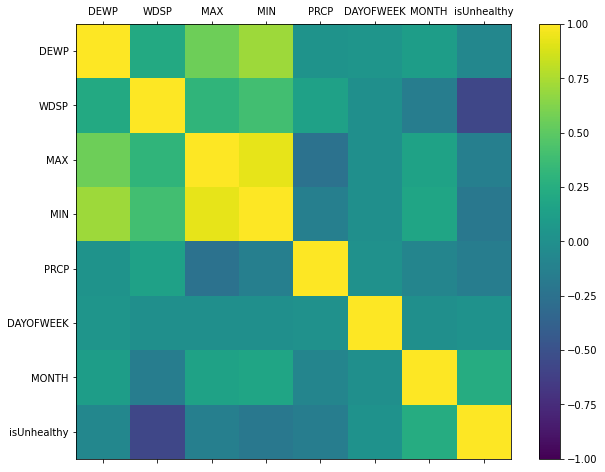

In [13]:
# Visualize correlations in our merged dataframe...
correlations = merged_df.corr()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, len(merged_df.columns), 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(merged_df.columns)
ax.set_yticklabels(merged_df.columns)
plt.show()

In [14]:
# Additional import statements for autogluon+sklearn and split our data...
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
train_df, validate_df = train_test_split(merged_df, test_size=0.33, random_state=1)
train_df.shape, validate_df.shape
print('Number of training samples:', len(train_df))
print('Number of validation samples:', len(validate_df))

Number of training samples: 1476
Number of validation samples: 727


In [15]:
#Get test data and remove the target label column...
test_df=validate_df.drop([targetLabelName],axis=1)
display(test_df)

,DEWP,WDSP,MAX,MIN,PRCP,DAYOFWEEK,MONTH
510,63.5,5.1,98.1,73.9,0.00,3,9
1045,40.2,4.4,66.0,39.9,0.00,2,3
1059,42.7,3.4,78.1,46.9,0.00,2,3
406,52.9,9.4,99.0,64.9,0.00,5,5
693,40.5,6.4,62.1,44.1,0.04,4,3
...,...,...,...,...,...,...,...
631,51.8,3.6,66.0,48.9,0.00,7,1
1935,50.7,7.0,98.1,70.0,0.00,6,9
34,39.6,14.3,72.0,46.0,0.00,5,4
851,48.6,5.6,102.0,64.9,0.00,2,8


In [16]:
# Use AutoGluon TabularPredictor to fit a model for our training data...
modelPath = f'AutogluonModels/aq_{locations.active.name}_{locations.active.yearStart}-{locations.active.yearEnd}_{aqParams.target.name}/'
predictor = TabularPredictor(label=targetLabelName, eval_metric=eval_metric, path=modelPath)
predictor.fit(train_data=train_df, time_limit=time_limit_secs, verbosity=2, presets='best_quality')

Presets specified: ['best_quality']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/aq_fresno_2016-2022_pm25/"
AutoGluon Version:  0.4.2
Python Version:     3.9.13
Operating System:   Linux
Train Data Rows:    1476
Train Data Columns: 7
Label Column: isUnhealthy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    14618.81 MB
	Train Data (Original)  Memory Usage: 0.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feat

In [17]:
# Get dataframes for feature correlation + leaderboard AND display model evaluation...
featureimp_df  = predictor.feature_importance(validate_df)
leaderboard_df = predictor.leaderboard(validate_df, silent=True)
display(predictor.evaluate(validate_df, auxiliary_metrics=False))

Computing feature importance via permutation shuffling for 7 features using 727 rows with 5 shuffle sets...
	88.9s	= Expected runtime (17.78s per shuffle set)
	21.15s	= Actual runtime (Completed 5 of 5 shuffle sets)
Evaluation: accuracy on test data: 0.8363136176066025
Evaluations on test data:
{
    "accuracy": 0.8363136176066025
}


{'accuracy': 0.8363136176066025}

In [18]:
# View (and/or plot) leaderboard...
display(leaderboard_df)
# leaderboard_df.plot(kind="bar", legend=False, figsize=(16, 4), x="model", y="score_val", xlabel="model", ylabel="score_val")

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1,0.839065,0.830623,0.102060,0.036217,8.281852,0.102060,0.036217,8.281852,1,True,13
1,RandomForestEntr_BAG_L1,0.837689,0.823171,0.125343,0.152951,0.679810,0.125343,0.152951,0.679810,1,True,6
2,XGBoost_BAG_L1,0.836314,0.845528,0.056381,0.054986,4.796713,0.056381,0.054986,4.796713,1,True,11
3,ExtraTreesEntr_BAG_L1,0.836314,0.822493,0.134073,0.157970,0.653227,0.134073,0.157970,0.653227,1,True,9
4,CatBoost_BAG_L2,0.836314,0.861111,1.167175,1.176113,70.931061,0.015080,0.010589,11.931422,2,True,19
5,WeightedEnsemble_L3,0.836314,0.863144,1.478986,1.362638,97.887236,0.003211,0.002975,0.854933,3,True,26
6,RandomForestGini_BAG_L1,0.834938,0.823171,0.129168,0.163234,0.881559,0.129168,0.163234,0.881559,1,True,5
7,RandomForestEntr_BAG_L2,0.834938,0.846883,1.274919,1.318585,59.743916,0.122824,0.153060,0.744277,2,True,18
8,ExtraTreesEntr_BAG_L2,0.834938,0.841463,1.277499,1.328700,59.665330,0.125405,0.163176,0.665691,2,True,21
9,LightGBM_BAG_L1,0.833563,0.845528,0.040303,0.030872,6.264384,0.040303,0.030872,6.264384,1,True,4


,importance,stddev,p_value,n,p99_high,p99_low
WDSP,0.203026,0.011409,0.000001,5,0.226518,0.179534
MONTH,0.071802,0.006905,0.000010,5,0.086019,0.057584
MAX,0.039065,0.007187,0.000131,5,0.053863,0.024267
MIN,0.022008,0.005916,0.000571,5,0.034190,0.009826
PRCP,0.014856,0.005705,0.002166,5,0.026602,0.003110
DEWP,0.010179,0.008946,0.031849,5,0.028599,-0.008241
DAYOFWEEK,0.001651,0.002646,0.117748,5,0.007098,-0.003797


<AxesSubplot:xlabel='feature'>

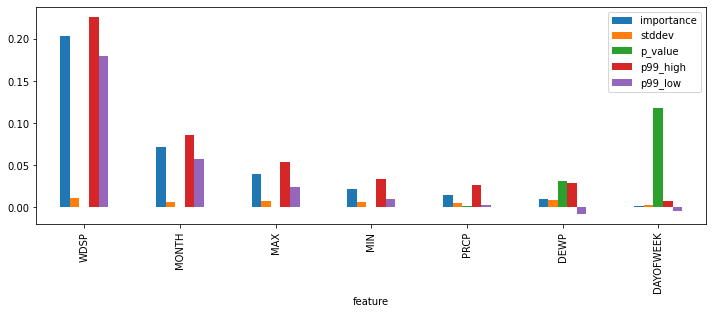

In [19]:
# View (and/or Plot) Leaderboard...
display(featureimp_df)
featureimp_df.drop(columns=["n"]).plot(kind="bar", figsize=(12, 4), xlabel="feature")

In [20]:
# Make Predictions...
y_pred = predictor.predict(test_df)
display(y_pred)

510     1
1045    0
1059    0
406     0
693     0
       ..
631     1
1935    0
34      0
851     1
1938    1
Name: isUnhealthy, Length: 727, dtype: int64

In [21]:
# Get true label values...
y_true = validate_df[targetLabelName]
display(y_true)

510     0
1045    0
1059    0
406     0
693     0
       ..
631     0
1935    0
34      0
851     1
1938    1
Name: isUnhealthy, Length: 727, dtype: int64

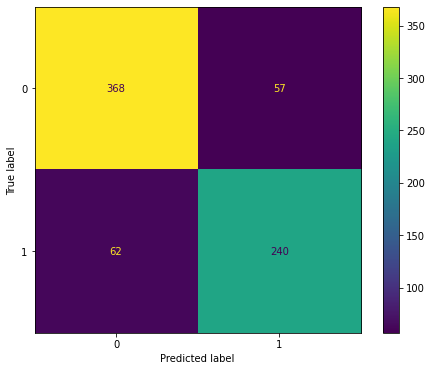

In [22]:
# View Confusion Matrix...
cm  = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax)

In [23]:
# Create and save final results...
results_df = pd.DataFrame()
results_df['PREDICTION'] = pd.DataFrame(y_pred)
results_df = pd.concat([validate_df, results_df], axis=1)
results_df.to_csv(f'dataRESULTS_{locations.active.name}_{locations.active.yearStart}-{locations.active.yearEnd}_{aqParams.target.name}.csv', index=False)